In [1]:
import pandas as pd
import re 

reviews = pd.read_csv('../Data/Cleaned Data/final_dataset_cleaned.csv')

reviews = reviews.dropna()


print(reviews.shape)

(97529, 17)


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

import nltk
import string

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')


# email module has some useful functions
import os, sys, email,re



In [3]:
def generate_wordclouds(X, in_X_tfidf, k, in_word_positions):

    # Clustering
    in_model = KMeans(n_clusters=k, random_state=42, n_jobs=-1)
    in_y_pred = in_model.fit_predict(X)
    in_cluster_ids = set(in_y_pred)
    silhouette_avg = silhouette_score(X, in_y_pred)
    print("For n_clusters =", k, "The average silhouette_score is :", silhouette_avg)

    # Number of words with highest tfidf score to display
    top_count = 100

    for in_cluster_id in in_cluster_ids:
        # compute the total tfidf for each term in the cluster
        in_tfidf = in_X_tfidf[in_y_pred == in_cluster_id]
        # numpy.matrix
        tfidf_sum = np.sum(in_tfidf, axis=0)
        # numpy.array of shape (1, X.shape[1])
        tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
        top_indices = tfidf_sum.argsort()[-top_count:]
        term_weights = {in_word_positions[in_idx]: tfidf_sum[in_idx] for in_idx in top_indices}
        wc = WordCloud(width=1200, height=800, background_color="white")
        wordcloud = wc.generate_from_frequencies(term_weights)
        fig, ax = plt.subplots(figsize=(10, 6), dpi=100)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        fig.suptitle(f"Cluster {in_cluster_id}")
        plt.show()
        text = "wordcloud"
        ext = ".jpg"
        filename = text + k + ext 
        wordcloud.to_file(filename)
    return in_cluster_ids


def custom_import_stopwords(filename):
    in_stopword_list = []
    in_flag = 0
    in_word_cnt = 0

    with open(filename, encoding="utf8") as f:
        for row in csv.reader(f):
            if in_flag == 0:
                in_flag = 1
            else:
                in_stopword_list.append(row[0])
                in_word_cnt += 1

    print(f"{in_word_cnt} stopwords imported")
    return in_stopword_list

In [4]:
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
class LemmaTokenizer(object):

    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def __call__(self, document):
        lemmas = []
        
        # Pre-proccessing of one document at the time
        
        # Removing puntuation
        translator_1 = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
        document = document.translate(translator_1)

        # Removing numbers
        document = re.sub(r'\d+', ' ', document)

        # Removing special characters
        document = re.sub(r"[^a-zA-Z0-9]+", ' ', document)

        # The document is a string up to now, after word_tokenize(document) we'll work on every word one at the time
        for token in word_tokenize(document):
            
            # Removing spaces
            token = token.strip()
            
            # Lemmatizing
            token = self.lemmatizer.lemmatize(token)

            # Removing stopwords
            if len(token) > 2:
                lemmas.append(token)
        return lemmas

In [5]:
reviews['review_cleaned'].str.lower().str.split()

results = set()
reviews['review_cleaned'].str.lower().str.split().apply(results.update)
print(len(results))

#34k unique words

34888


In [6]:

from sklearn.feature_extraction.text import TfidfVectorizer
data = reviews['review_cleaned']

# we will use tfidf for 20000 features first

tf_idf_vectorizor = TfidfVectorizer(stop_words = 'english', tokenizer=LemmaTokenizer())

tf_idf = tf_idf_vectorizor.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()


print("Shape of the array:",tf_idf_array.shape)
percentzero = np.count_nonzero(tf_idf_array==0)/(tf_idf_array.shape[0]*tf_idf_array.shape[1])*100
print("Percentage of zeros:",
      percentzero)
print("Percentage filled:", 100 - percentzero )

Shape of the array: (97529, 31517)
Percentage of zeros: 99.94434803699905
Percentage filled: 0.05565196300095465


# for explained variance i will try to retain it at 60% and 80% and look at performance of the clustering models

In [ ]:
# # this is for 60% explained variance SVD 
# from sklearn.decomposition import TruncatedSVD

# svd = TruncatedSVD(n_components=1000, random_state=42)
# X_svd = svd.fit_transform(tf_idf)
# print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

In [16]:
# this is for 80% explained variance SVD 
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2000, random_state=42)
X_svd = svd.fit_transform(tf_idf)
print(f"Total variance explained: {np.sum(svd.explained_variance_ratio_):.2f}")

Total variance explained: 0.77


In [ ]:
# # this is for 60% explained variance PCA 

# NUM_COMPONENTS = 1000

# sklearn_pca = PCA(NUM_COMPONENTS)
# Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)

# variance_explained = np.cumsum(sklearn_pca.explained_variance_)

# print(len(Y_sklearn[0]))

# fig, ax = plt.subplots(figsize=(15, 8))
# plt.plot(range(NUM_COMPONENTS),variance_explained, color='r')
# ax.grid(True)
# plt.xlabel("Number of components")
# plt.ylabel("Cumulative explained variance")

In [ ]:
# # this is for 80% explained variance PCA 

# NUM_COMPONENTS = 2000

# sklearn_pca = PCA(NUM_COMPONENTS)
# Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)

# variance_explained = np.cumsum(sklearn_pca.explained_variance_)

# print(len(Y_sklearn[0]))

# fig, ax = plt.subplots(figsize=(15, 8))
# plt.plot(range(NUM_COMPONENTS),variance_explained, color='r')
# ax.grid(True)
# plt.xlabel("Number of components")
# plt.ylabel("Cumulative explained variance")

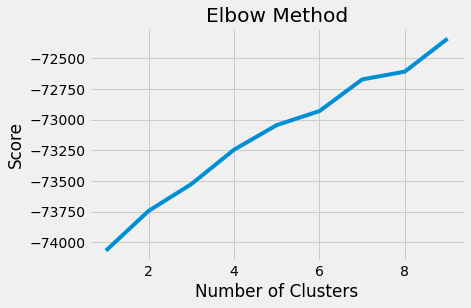

In [18]:

number_clusters = range(1, 10)

kmeans = [KMeans(n_clusters=i, max_iter = 100) for i in number_clusters]
kmeans

score = [kmeans[i].fit(X_svd).score(X_svd) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

C:\Users\Shawn\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


For n_clusters = 3 The average silhouette_score is : 0.006421508230755089


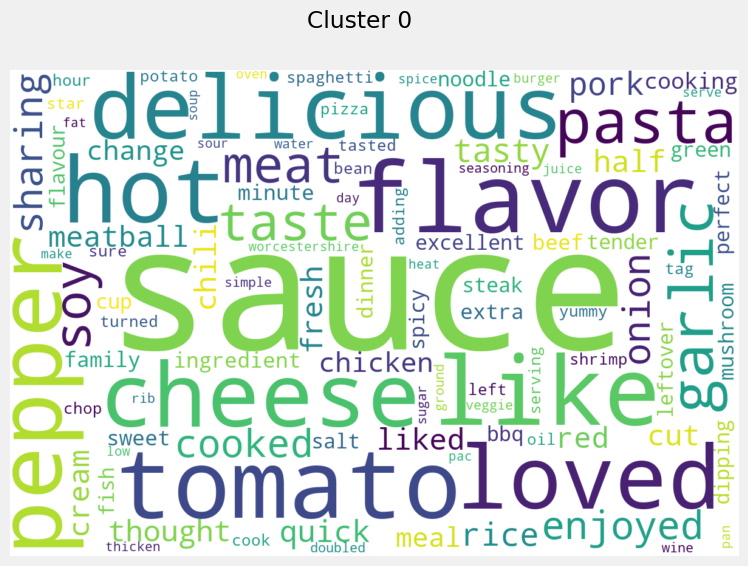

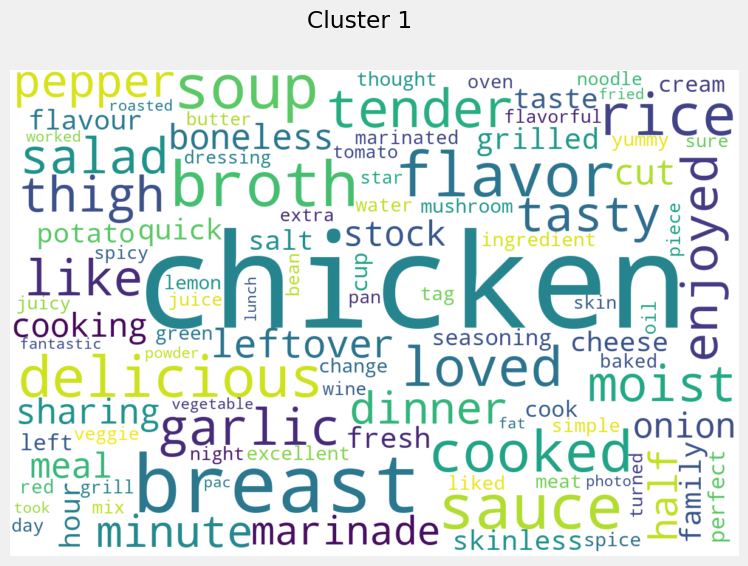

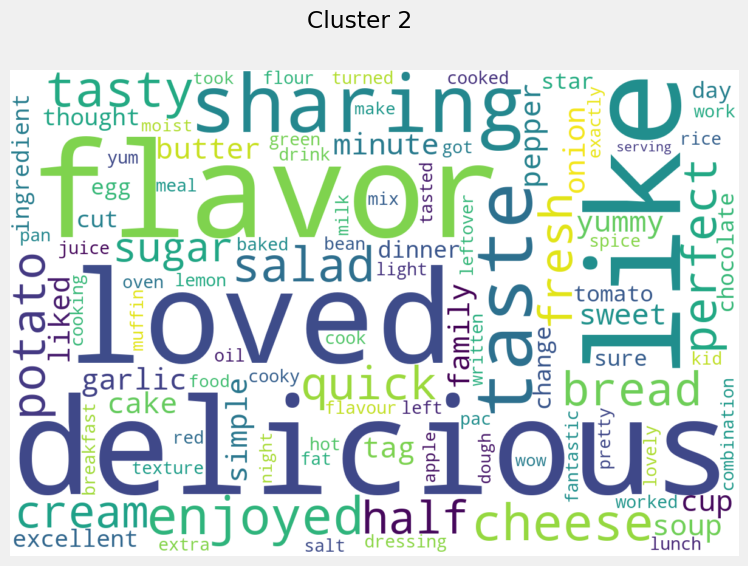

In [21]:
word_positions = {v: k for k, v in tf_idf_vectorizor.vocabulary_.items()}
# cluster_ids = generate_wordclouds(X_svd, tf_idf, 2, word_positions) # The average silhouette_score is :  0.008336525997926818
cluster_ids = generate_wordclouds(X_svd, tf_idf, 3, word_positions) # The average silhouette_score is : 0.006421508230755089
# cluster_ids = generate_wordclouds(X_svd, tf_idf, 4, word_positions) # The average silhouette_score is : 0.004229255251152468
# cluster_ids = generate_wordclouds(X_svd, tf_idf, 5, word_positions) # The average silhouette_score is : 0.004229255251152468
# cluster_ids = generate_wordclouds(X_svd, tf_idf, 6, word_positions) # The average silhouette_score is : 0.004229255251152468

In [ ]:
# model = KMeans(n_clusters=4, random_state=42, n_jobs=-1)
# y_pred = model.fit_predict(X_svd)
# cluster_ids = set(y_pred)

# min_support = 0.3
# dist_words = sorted(v for k, v in word_positions.items()) # distinct words in the vocabulary
# for cluster_id in cluster_ids:
#     print(f"FP-Growth results on Cluster {cluster_id} with min support {min_support}")
#     tfidf = X_tfidf[y_pred == cluster_id]
#     # encoded as binary "presence/absence" representation as required by mlxtend
#     tfidf[tfidf > 0] = 1
#     # df is a pandas sparse dataframe
#     df = pd.DataFrame.sparse.from_spmatrix(tfidf, columns=dist_words)
#     fset = fpgrowth(df, min_support=min_support, use_colnames=True).sort_values(by='support', ascending=False)
#     print(fset, '\n')

1000


Text(0, 0.5, 'Cumulative explained variance')

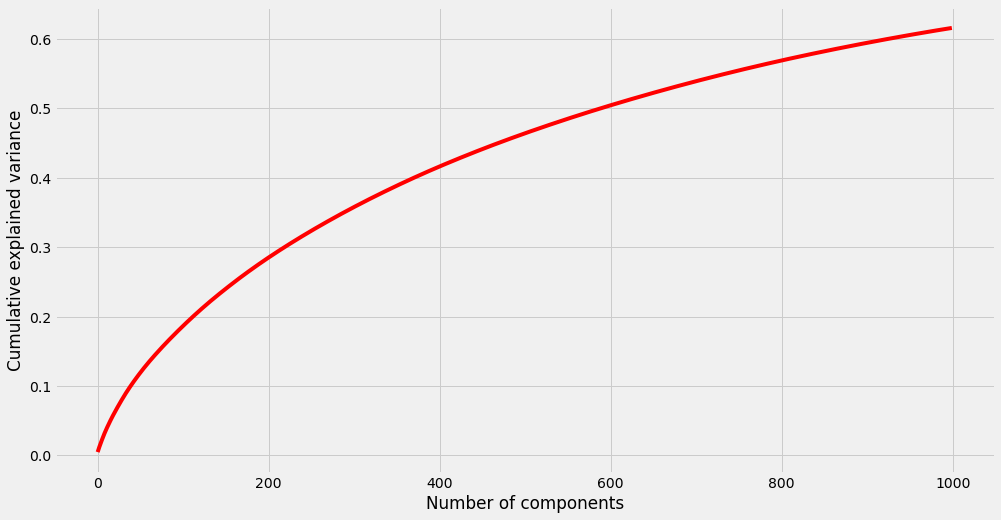

In [67]:
import matplotlib.pyplot as plt

NUM_COMPONENTS = 1000

sklearn_pca = PCA(NUM_COMPONENTS)

Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)

variance_explained = np.cumsum(sklearn_pca.explained_variance_)

print(len(Y_sklearn[0]))

fig, ax = plt.subplots(figsize=(15, 8))
plt.plot(range(NUM_COMPONENTS),variance_explained, color='r')
ax.grid(True)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
